
# 1) Frequent Words = Literary Fingerprints

This notebook compares **word frequency** between our two toy texts:
- *The Fellowship of the Ring* (here referenced as **Fellowship**)
- *The Return of the King* (here referenced as **TheKing**)

We practice simple tokenization and frequency analysis, then discuss
what's **meaningful signal** vs. **noise** in the results, and how to
improve the method (normalization, keyness, etc).


# Setup: Load Texts

This notebook needs **The Fellowship of the Ring** and **The Return of the King** as input texts.

**How to provide the texts:**

1. Download the following books as `.txt` files:

   

2. Place two text files in the "data" folder with names:
   - `Fellowship.txt`  (The Fellowship of the Ring)
   - `TheKing.txt` (The Return of the King)





In [24]:
from pathlib import Path
import re
from collections import Counter
import math
import matplotlib.pyplot as plt

In [12]:
def load_texts(fellowship: str = '..\\data\\Fellowship.txt',
               towers: str = '..\\data\\TwoTowers.txt',
               theking: str = '..\\data\\TheKing.txt'):
    
    p1, p2, p3 = Path(fellowship), Path(towers), Path(theking)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please make sure 'Fellowship.txt' is in the 'data' folder."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please make sure 'TwoTowers.txt' is in the 'data' folder."
        )
    if not p3.exists():
        raise FileNotFoundError(
            f"Missing file: {p3}\n"
            "→ Please make sure 'TheKing.txt' is in the 'data' folder."
        )

    # Read the files
    fellowship = p1.read_text(encoding='utf-8', errors='ignore')
    twotowers = p2.read_text(encoding='utf-8', errors='ignore')
    theking = p3.read_text(encoding='utf-8', errors='ignore')
    return fellowship, twotowers, theking

In [13]:
def normalize(text: str, is_p1: bool = False, is_p2: bool = False, is_p3: bool = False) -> str:
    """Normalize a text for tokenization."""
    if not text:
        return ''
    
    # If it's Fellowship, skip the Foreword and Prologue
    if is_p1:
        prologue_end = text.find('Chapter 1\n\nA Long-expected Party')
        if prologue_end != -1:
            text = text[prologue_end:]
    
    # For Return of the King
    if is_p2:
        contents_end = text.find('_Chapter 1_\nThe Departure of Boromir')
        if contents_end != -1:
            text = text[contents_end:]

    if is_p3:
        contents_end = text.find('Book V\n\nChapter 1. Minas Tirith')
        if contents_end != -1:
            text = text[contents_end:]

    return text.replace('\r\n', '\n')

In [15]:
# This new regex finds words like "don't" but skips junk like "'s"
WORD_RE = re.compile(r"\b[A-Za-z][A-Za-z']*\b") 

def words(text: str):
    """Smarter word tokenizer (lowercased, ASCII letters + internal apostrophes)."""
    return WORD_RE.findall(text.lower())


def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries."""
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

In [26]:
def top_words(words, min_len=4, extra_stop=None, n=30):
    base_stop = {
        'the','and','to','of','a','i','it','in','that','was','he','you','is','for','on','as',
        'with','his','her','at','be','she','had','not','but','said','they','them','this','so','all','one','very',
        'there','what','were','from','have','would','could','when','been','their','we','my','me','or','by','up','no','out','if',
        # book-specific names are often noise for stylistics; tweak as needed
        'frodo','gandalf','samwise','sam','meriadoc','peregrin','aragorn','legolas','gimli',
        'boromir','sauron','saruman','gollum','elrond','galadriel','celeborn','treebeard','théoden',
        'denethor','faramir','bilbo','tom','bombadil','shelob'
    }
    if extra_stop:
        base_stop |= set(extra_stop)

    c = Counter(w for w in words if len(w) >= min_len and w not in base_stop)
    return c.most_common(n)

In [17]:
def per_10k(count: int, total_words: int) -> float:
    """Normalize a raw count per 10,000 words for fair comparisons."""
    return (count / max(1, total_words)) * 10000.0


def log_likelihood(k1: int, n1: int, k2: int, n2: int) -> float:
    """Dunning’s log-likelihood (G^2) keyness score for word distinctiveness."""
    E1 = n1 * (k1 + k2) / max(1, (n1 + n2))
    E2 = n2 * (k1 + k2) / max(1, (n1 + n2))

    def term(k, E):
        return 0.0 if k == 0 or E == 0 else k * math.log(k / E)

    return 2.0 * (term(k1, E1) + term(k2, E2))


## Load & Normalize
We load both texts using **inline path checks** and then apply a simple normalization.


In [19]:

# Load raw texts
fellowship_raw, twotowers_raw, theking_raw = load_texts()

# Normalize for tokenization
# We pass is_fellowship=True to tell our new function to skip the prologue
fellowship   = normalize(fellowship_raw, is_p1=True)
twotowers  = normalize(twotowers_raw, is_p2=True)
theking = normalize(theking_raw, is_p3 = True) 

# Update the print labels
print(f"Fellowship chars: {len(fellowship):,} | Two Towers chars: {len(twotowers):,} | Return of the King chars: {len(theking):,}")


Fellowship chars: 948,198 | Two Towers chars: 834,448 | Return of the King chars: 709,796



## Tokenize
We use a simple regex tokenizer (letters + apostrophes). For more serious work,
consider spaCy or stanza for tagging and lemmatization.


In [22]:
# --- Run the tokenizers ---
fellowship_words = words(fellowship)
twotowers_words = words(twotowers)
return_king_words = words(theking)

fellowship_sentences = sentences(fellowship)
twotowers_sentences = sentences(twotowers)
return_king_sentences = sentences(theking)

# Save total word counts for later
nF = len(fellowship_words) # Total words in Fellowship
nT = len(twotowers_words)  # Total words in Two Towers
nR = len(return_king_words) # Total words in TheKing

print(f"Fellowship words: {nF:,} | Two Towers words: {nT:,} | TheKing words: {nR:,}")
print(f"Fellowship sentences: {len(fellowship_sentences):,} | Two Towers: {len(twotowers_sentences):,} | TheKing sentences: {len(return_king_sentences):,}")

Fellowship words: 179,144 | Two Towers words: 153,729 | TheKing words: 136,735
Fellowship sentences: 10,880 | Two Towers: 10,619 | TheKing sentences: 7,449



## Top Words (after basic stopwords)
The list is **partly signal, partly noise**—use it to start discussion.


In [28]:
print("Top Fellowship:", top_words(fellowship_words, n=15))
print("Top Two Towers:", top_words(twotowers_words, n=15))
print("Top Return of the King:", top_words(return_king_words, n=15))


Top Fellowship: [('will', 559), ('then', 549), ('into', 449), ('long', 421), ('came', 421), ('down', 418), ('again', 412), ('like', 403), ('more', 388), ('before', 378), ('come', 377), ('your', 347), ('some', 346), ('great', 335), ('back', 334)]
Top Two Towers: [('will', 568), ('then', 562), ('your', 440), ('down', 432), ('like', 411), ('long', 410), ('come', 404), ('great', 393), ('some', 389), ('into', 380), ('came', 365), ('more', 364), ('again', 361), ('back', 354), ('away', 344)]
Top Return of the King: [('will', 588), ('then', 573), ('came', 455), ('great', 443), ('come', 388), ('your', 335), ('more', 331), ('like', 302), ('down', 299), ('into', 293), ('before', 291), ('upon', 289), ('pippin', 282), ('long', 281), ('some', 275)]


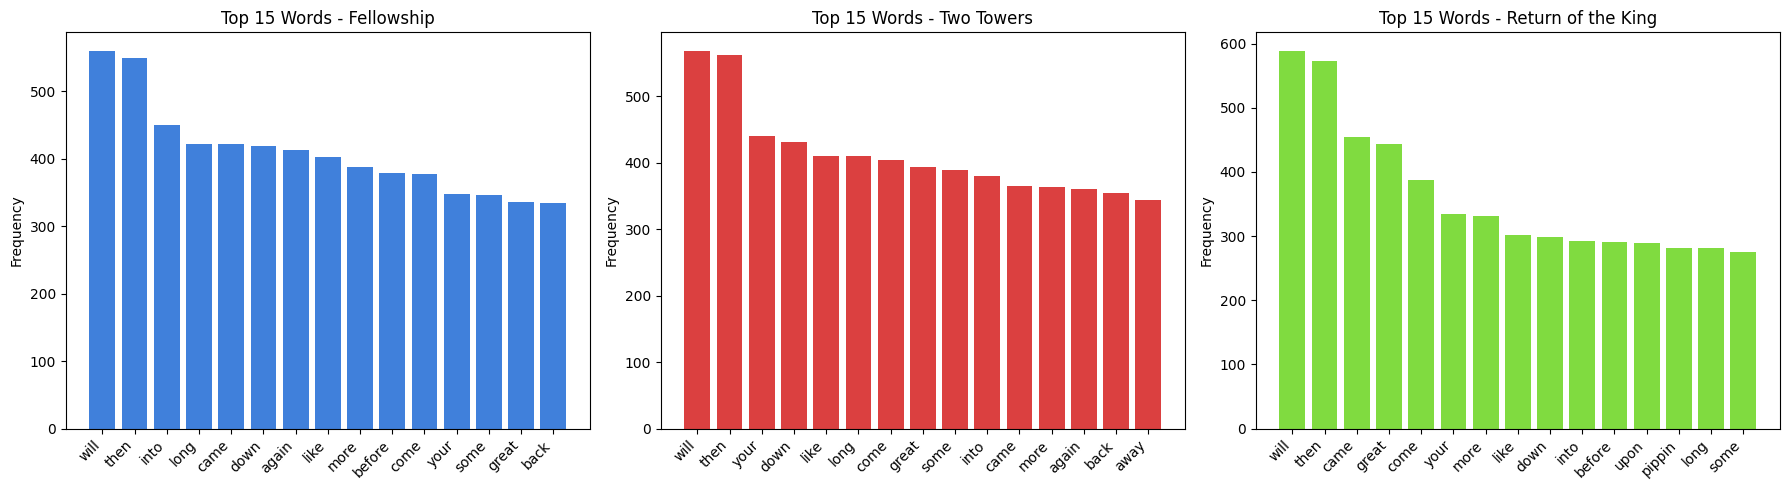

In [30]:
# Create a figure with 3 subplots (one for each book)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get top words for each book
fellowship_top = top_words(fellowship_words, n=15)
twotowers_top = top_words(twotowers_words, n=15)
returnking_top = top_words(return_king_words, n=15)

# Plot Fellowship
axes[0].bar(range(len(fellowship_top)), [count for word, count in fellowship_top], color='#4080DB')
axes[0].set_xticks(range(len(fellowship_top)))
axes[0].set_xticklabels([word for word, count in fellowship_top], rotation=45, ha='right')
axes[0].set_title('Top 15 Words - Fellowship')
axes[0].set_ylabel('Frequency')

# Plot Two Towers
axes[1].bar(range(len(twotowers_top)), [count for word, count in twotowers_top], color='#DB4040')
axes[1].set_xticks(range(len(twotowers_top)))
axes[1].set_xticklabels([word for word, count in twotowers_top], rotation=45, ha='right')
axes[1].set_title('Top 15 Words - Two Towers')
axes[1].set_ylabel('Frequency')

# Plot Return of the King
axes[2].bar(range(len(returnking_top)), [count for word, count in returnking_top], color='#80Db40')
axes[2].set_xticks(range(len(returnking_top)))
axes[2].set_xticklabels([word for word, count in returnking_top], rotation=45, ha='right')
axes[2].set_title('Top 15 Words - Return of the King')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Optional continution:


## Distinctiveness via Log-Likelihood (Keyness)
Raw frequency is not enough. Compute **G²** to find words that are *distinctive* of each book.


In [31]:
def per_10k(count: int, total_words: int) -> float:
    """Normalize a raw count per 10,000 words for fair comparisons."""
    return (count / max(1, total_words)) * 10000.0


def lolookingglass_likelihood(k1: int, n1: int, k2: int, n2: int) -> float:
    """Dunning’s log-likelihood (G^2) keyness score for word distinctiveness.

    Parameters
    ----------
    k1 : int  Frequency in corpus A
    n1 : int  Total words in corpus A
    k2 : int  Frequency in corpus B
    n2 : int  Total words in corpus B

    Returns
    -------
    float
        G^2 value; larger absolute values indicate stronger distinctiveness.
        Direction should be interpreted by comparing rates (per_10k) or counts.

    Notes
    -----
    - Symmetric measure widely used for corpus comparison.
    - Great classroom upgrade over raw frequency lists.
    """
    E1 = n1 * (k1 + k2) / max(1, (n1 + n2))
    E2 = n2 * (k1 + k2) / max(1, (n1 + n2))

    def term(k, E):
        return 0.0 if k == 0 or E == 0 else k * math.log(k / E)

    return 2.0 * (term(k1, E1) + term(k2, E2))


In [35]:
# Build frequency dictionaries
cf = Counter(fellowship_words)
ct = Counter(twotowers_words)
cr = Counter(return_king_words)
nF, nR = sum(cf.values()), sum(cr.values())

# Compare a candidate set (union of top ~500 from each to keep it fast)
candidates = set([w for w,_ in cf.most_common(500)] + [w for w,_ in cr.most_common(500)])

rows = []
for w in candidates:
    # (filter out any remaining stopwords that slipped through)
    if w in {'frodo', 'sam', 'pippin', 'merry', 'gandalf', 'aragorn', 'boromir', 'gimli', 'legolas', 'then', 'bilbo', 'samwise', 's', 't', 'll', 've', 'd', 're'}:
        continue
    
    # This line is now corrected (per_10k instead of per_1ci0k)
    g2 = log_likelihood(cf[w], nF, cr[w], nR)
    rows.append((g2, w, per_10k(cf[w], nF), per_10k(cr[w], nR)))

# Sort by distinctiveness (descending)
rows.sort(reverse=True)

print("--- 20 Most Distinctive Words (Log-Likelihood) ---")
print(f"{'WORD':>12}  {'G2_SCORE':>8}  {'FELLOWSHIP_RATE':>16}  {'RETURN_RATE':>12}")
print("-" * 52)

for g2, w, f10k, r10k in rows[:20]:
    # We check which rate is higher to label the "direction"
    if f10k > r10k:
        print(f"{w:>12}  {g2:8.1f}  {f10k:16.2f}  {r10k:12.2f}  (More in Fellowship)")
    else:
        print(f"{w:>12}  {g2:8.1f}  {f10k:16.2f}  {r10k:12.2f}  (More in Return of the King)")

--- 20 Most Distinctive Words (Log-Likelihood) ---
        WORD  G2_SCORE   FELLOWSHIP_RATE   RETURN_RATE
----------------------------------------------------
     faramir     271.3              0.00         11.85  (More in Return of the King)
        king     266.8              1.34         17.48  (More in Return of the King)
       don't     239.3             11.78          0.00  (More in Fellowship)
         men     203.6              6.25         25.74  (More in Return of the King)
        city     199.4              1.17         13.60  (More in Return of the King)
         don     165.8              0.00          7.24  (More in Return of the King)
        lord     164.0              3.41         17.33  (More in Return of the King)
    denethor     161.1              0.33          8.85  (More in Return of the King)
     strider     149.7             11.11          0.95  (More in Fellowship)
    beregond     122.2              0.00          5.34  (More in Return of the King)
      g

In [37]:
import pandas as pd
import altair as alt

print("\n--- Combined Character & Pronoun Focus Analysis ---")

# 1. Define all the terms you want to track in the graph
target_terms = [
    'he/him', 
    'she/her', 
    'gandalf', 
    'aragorn', 
    'frodo', 
    'sam',
    'boromir', 
    'bilbo',
    'faramir',
    'denethor'
]

# 2. Get the counts and rates for each term
combined_data = []

for term in target_terms:
    fellowship_count = 0
    twotowers_count = 0
    return_count = 0
    
    # Handle the special pronoun groups
    if term == 'he/him':
        fellowship_count = cf['he'] + cf['him']
        twotowers_count = ct['he'] + ct['him']
        return_count = cr['he'] + cr['him']
    elif term == 'she/her':
        fellowship_count = cf['she'] + cf['her']
        twotowers_count = ct['she'] + ct['her']
        return_count = cr['she'] + cr['her']
    # Handle regular names
    else:
        fellowship_count = cf[term]
        twotowers_count = ct[term]
        return_count = cr[term]
        
    # Add data for Fellowship
    combined_data.append({
        'Book': 'Fellowship',
        'Term': term,
        'Rate (per 10k words)': per_10k(fellowship_count, nF)
    })
    
    # Add data for Two Towers
    combined_data.append({
        'Book': 'TwoTowers',
        'Term': term,
        'Rate (per 10k words)': per_10k(twotowers_count, nT)
    })
    
    # Add data for TheKing
    combined_data.append({
        'Book': 'TheKing',
        'Term': term,
        'Rate (per 10k words)': per_10k(return_count, nR)
    })

# 3. Create a DataFrame
chart_df = pd.DataFrame(combined_data)

# 4. Build the Grouped Bar Chart with custom colors
chart = alt.Chart(chart_df).mark_bar().encode(
    # Set the x-axis to the Book name
    x=alt.X('Book', axis=None),
    
    # Set the y-axis to the normalized rate
    y=alt.Y('Rate (per 10k words)'),
    
    # Color the bars based on the Book with custom colors
    color=alt.Color('Book', 
                    scale=alt.Scale(
                        domain=['Fellowship', 'TwoTowers', 'TheKing'],
                        range=['#4080DB', '#DB4040', '#80DB40']
                    )),
    
    # Create grouped columns, one for each "Term"
    column=alt.Column('Term', sort=target_terms, header=alt.Header(titleOrient="bottom", labelOrient="bottom")),
    
    tooltip=['Book', 'Term', alt.Tooltip('Rate (per 10k words)', format='.2f')]
).properties(
    title='Combined Character & Pronoun Focus: Fellowship vs. Two Towers vs. TheKing'
).interactive()

# 5. Save and Display the Chart
chart.save('combined_character_focus_chart.json')
print("Graph saved to 'combined_character_focus_chart.json'")

chart


--- Combined Character & Pronoun Focus Analysis ---
Graph saved to 'combined_character_focus_chart.json'


alt.Chart(...)